# ASL Alphabet Detection

## Data Analysis

In [27]:
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Activation,
    BatchNormalization,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers

import warnings

warnings.filterwarnings("ignore")

In [28]:
# Set seeds for reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [29]:
data = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"


def create_dataframe(data_path):
    filepaths = []
    labels = []

    folds = os.listdir(data_path)

    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)

        for img in imgs:
            img_path = os.path.join(f_path, img)

            filepaths.append(img_path)
            labels.append(fold)

    fseries = pd.Series(filepaths, name="Filepaths")
    lseries = pd.Series(labels, name="Labels")

    return pd.concat([fseries, lseries], axis=1)


df = create_dataframe(data)

In [30]:
target_size = (64, 64)
target_dims = (64, 64, 3)
n_classes = 29

train_size, test_size = 0.7, 0.2
validation_size = 1 - (train_size + test_size)
validation_test_proportion = validation_size / (validation_size + test_size)

batch_size = 64
epochs = 10

In [31]:
train_df, dummy_df = train_test_split(
    df, train_size=train_size, shuffle=True, random_state=SEED
)
valid_df, test_df = train_test_split(
    dummy_df, train_size=validation_test_proportion, shuffle=True, random_state=SEED
)

In [32]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Filepaths",
    y_col="Labels",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42,
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="Filepaths",
    y_col="Labels",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Filepaths",
    y_col="Labels",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

Found 60899 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
Found 17401 validated image filenames belonging to 29 classes.


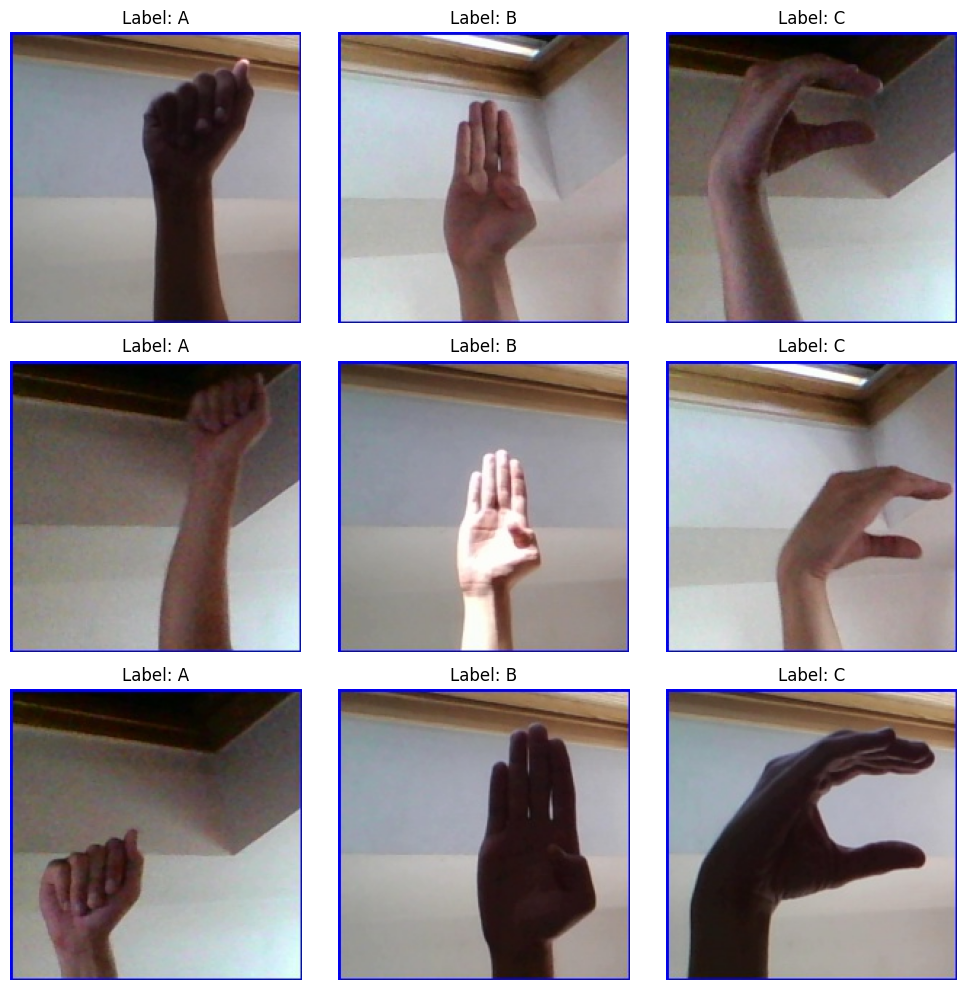

In [33]:
def plot_samples(df, labels, num_samples_per_label=3):
    plt.figure(figsize=(10, 10))
    for label_idx, label in enumerate(labels):
        label_df = df[df["Labels"] == label]

        rand_indices = random.sample(
            range(len(label_df)), min(num_samples_per_label, len(label_df))
        )

        for i, rand_idx in enumerate(rand_indices):
            img_path = label_df.iloc[rand_idx]["Filepaths"]
            label = label_df.iloc[rand_idx]["Labels"]

            img = plt.imread(img_path)
            plt.subplot(
                len(labels), num_samples_per_label, len(labels) * i + label_idx + 1
            )
            plt.imshow(img)
            plt.title(f"Label: {label}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


labels = ["A", "B", "C"]
plot_samples(train_df, labels)

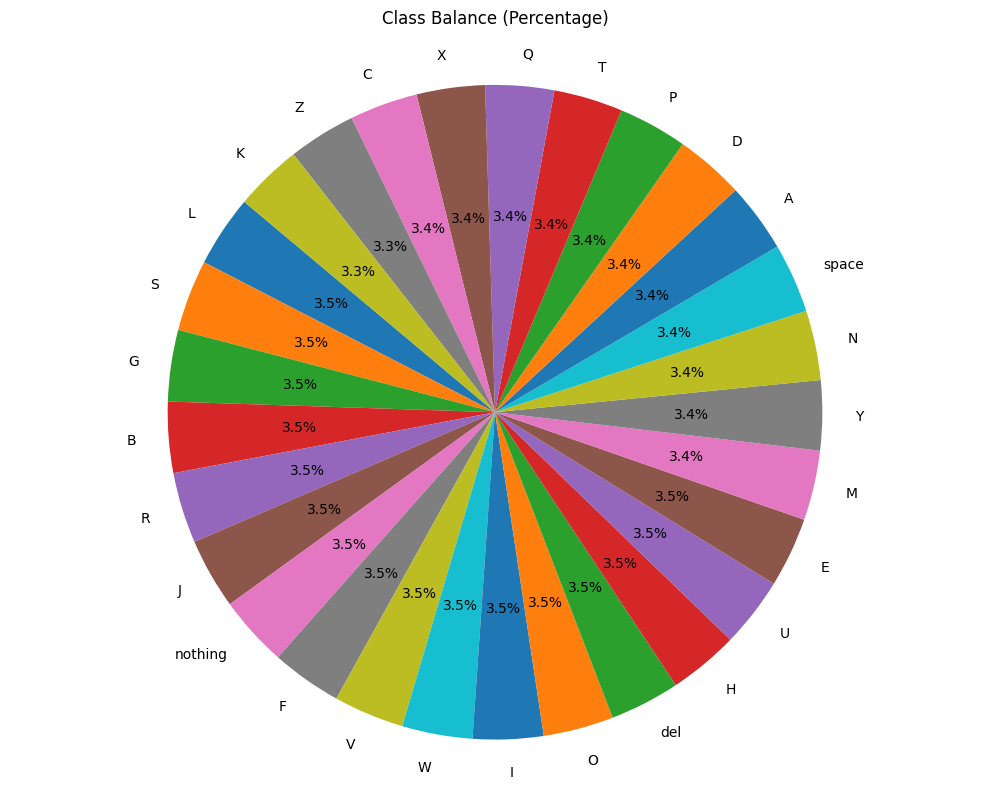

In [34]:
class_counts = train_df["Labels"].value_counts().reset_index()
class_counts.columns = ["Class", "Count"]

total_images = len(train_df)

class_counts["Percentage"] = (class_counts["Count"] / total_images) * 100

class_counts = class_counts.sort_values(by="Count", ascending=False)

plt.figure(figsize=(10, 8))
plt.pie(
    class_counts["Percentage"],
    labels=class_counts["Class"],
    autopct="%1.1f%%",
    startangle=140,
)
plt.title("Class Balance (Percentage)\n")
plt.axis("equal")
plt.tight_layout()
plt.show()

## Model Specification

In [35]:
inputs = tf.keras.Input(shape=target_dims)


# Depth-wise separable convolution block
def mobilenet_block(x, filters, strides):
    x = tf.keras.layers.DepthwiseConv2D(
        (3, 3), strides=strides, padding="same", activation="relu"
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(
        filters, (1, 1), strides=(1, 1), padding="same", activation="relu"
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x


x = tf.keras.layers.Conv2D(
    32, (3, 3), strides=(2, 2), padding="same", activation="relu"
)(inputs)

x = mobilenet_block(x, 64, (1, 1))
x = mobilenet_block(x, 128, (2, 2))
x = mobilenet_block(x, 128, (1, 1))
x = mobilenet_block(x, 256, (2, 2))
x = mobilenet_block(x, 256, (1, 1))
x = mobilenet_block(x, 512, (2, 2))

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(29, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

adam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adam"
)

model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

## Model Train

In [36]:
best_model_path = "best_model.weights.h5"
save_best_model = tf.keras.callbacks.ModelCheckpoint(
    best_model_path, monitor="val_loss", save_best_only=True, save_weights_only=True
)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    callbacks=[save_best_model],
)

model.load_weights(best_model_path)

Epoch 1/10
952/952 ━━━━━━━━━━━━━━━━━━━━ 311s 311ms/step - accuracy: 0.2686 - loss: 2.4433 - val_accuracy: 0.6121 - val_loss: 1.1826
Epoch 2/10
952/952 ━━━━━━━━━━━━━━━━━━━━ 151s 157ms/step - accuracy: 0.7736 - loss: 0.6632 - val_accuracy: 0.7302 - val_loss: 0.8690
Epoch 3/10
952/952 ━━━━━━━━━━━━━━━━━━━━ 150s 156ms/step - accuracy: 0.8813 - loss: 0.3483 - val_accuracy: 0.9495 - val_loss: 0.1478
Epoch 4/10
952/952 ━━━━━━━━━━━━━━━━━━━━ 149s 156ms/step - accuracy: 0.9188 - loss: 0.2452 - val_accuracy: 0.9631 - val_loss: 0.1052
Epoch 5/10
952/952 ━━━━━━━━━━━━━━━━━━━━ 152s 159ms/step - accuracy: 0.9331 - loss: 0.2011 - val_accuracy: 0.9045 - val_loss: 0.3264
Epoch 6/10
952/952 ━━━━━━━━━━━━━━━━━━━━ 162s 169ms/step - accuracy: 0.9480 - loss: 0.1577 - val_accuracy: 0.9484 - val_loss: 0.1631
Epoch 7/10
952/952 ━━━━━━━━━━━━━━━━━━━━ 151s 158ms/step - accuracy: 0.9524 - loss: 0.1446 - val_accuracy: 0.9491 - val_loss: 0.1595
Epoch 8/10
952/952 ━━━━━━━━━━━━━━━━━━━━ 151s 157ms/step - accuracy: 0.9583 -

## Model Test

In [40]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9903 - loss: 0.0275
Test Accuracy: 0.9895408153533936
Test Loss: 0.02864803373813629


272/272 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step


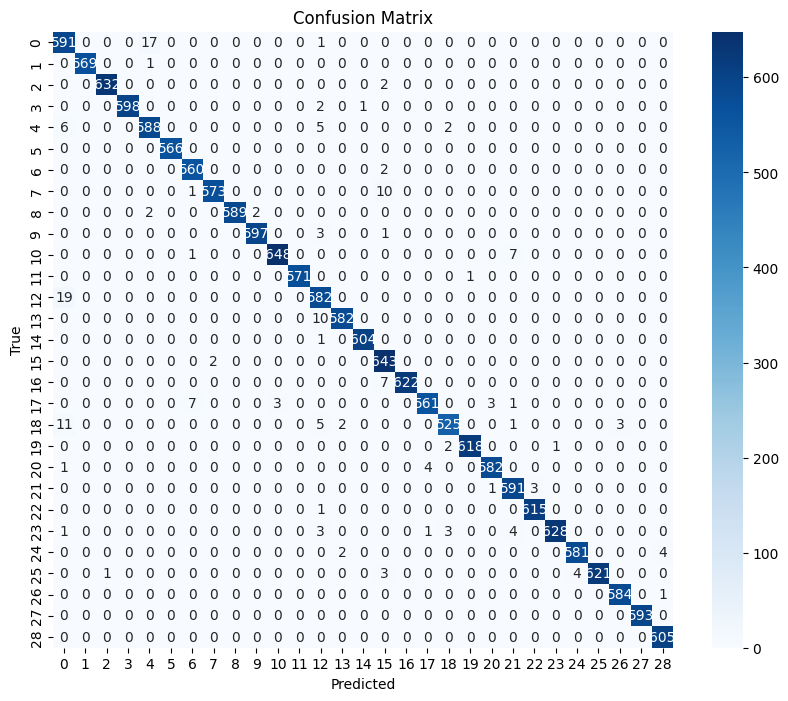

In [38]:
# Compute the confusion matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Model Metrics

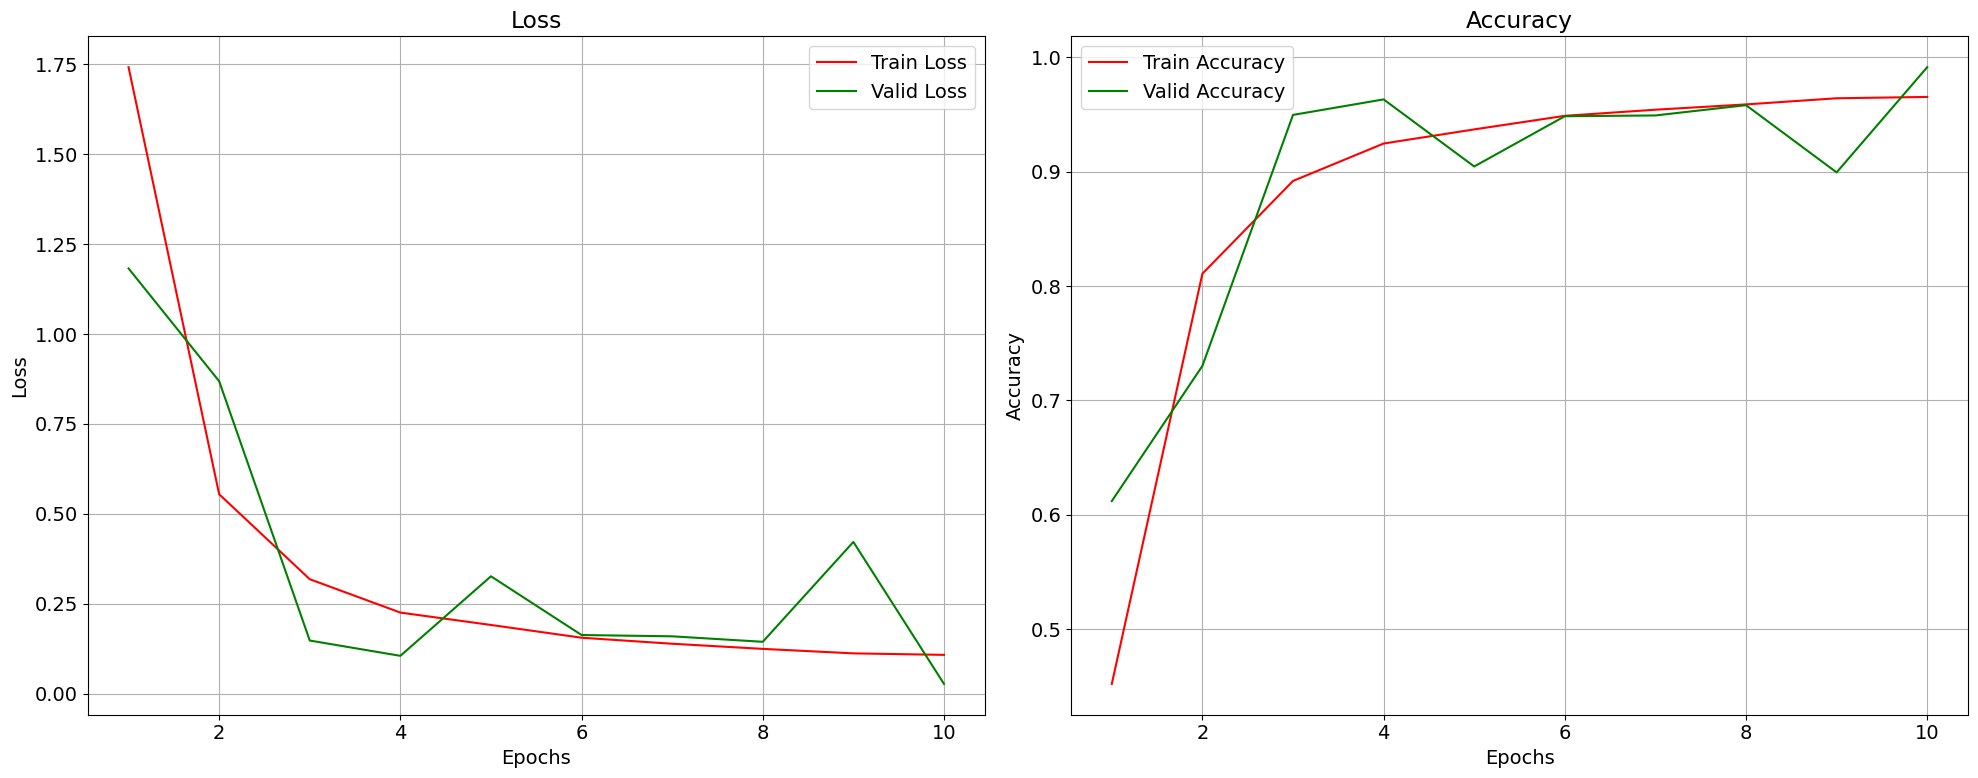

In [39]:
plt.rcParams.update({"font.size": 14})  # Set font size

tr_acc = history.history["accuracy"]
tr_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

epochs = [i + 1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, "r", label="Train Loss")
plt.plot(epochs, val_loss, "g", label="Valid Loss")
plt.title("Loss")
plt.legend()
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, "r", label="Train Accuracy")
plt.plot(epochs, val_acc, "g", label="Valid Accuracy")
plt.title("Accuracy")
plt.legend()
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()